# Residual bias correction of Mean-field GF
This is the full computation of the residual bias correction for our (mean-field) GF solution for the percolation problem (immobile "solute" with vacancy diffusion). It work through all of the matrix averages "analytically" (storing them as polynomials in the concentration of the immobile solute, $c_\text{B}$), and then brings everything together to express the residual bias correction as an analytic function with numerical coefficients for the square lattice.

In [365]:
import sys
sys.path.extend(['.','./Vacancy'])
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import scipy.sparse
import itertools
from numba import jit, njit, prange, guvectorize  # faster runtime with update routines
from scipy.misc import comb
# from sympy import *
import onsager.PowerExpansion as PE
import onsager.crystal as crystal
import onsager.crystalStars as stars
import onsager.GFcalc as GFcalc
from tqdm import tnrange, tqdm_notebook

In [ ]:
# Turn off or on to run optional testing code in notebook:
# Also turns on / off progress bars
__TESTING__ = False

Now, we need to expand out our probability factors. Let $x$ be the concentration of solute B; imagine we have $N$ sites possible. Then, if there are $n$ B atoms, the probability factor is
$$P(n;N) = x^n (1-x)^{N-n} = x^n \sum_{j=0}^{N-n} \frac{(N-n)!}{j!(N-n-j)!} (-x)^j
= \sum_{j=0}^{N-n} \frac{(N-n)!}{j!(N-n-j)!} (-1)^j x^{n+j}$$
The factorial term is $N-n$ choose $j$, which is `scipy.misc.comb`.

We want to construct a probability matrix `P[n,c]` such that $P(n;N)$ is written as a sum over $x^c$ terms; $c=0\ldots N$.

In [2]:
def calc_P(N):
    """
    Returns the probability matrix P[n,c] where the probability of seeing `n` atoms
    of type B in `N` sites is sum(c=0..N, x^c P[n,c])
    
    :param N: total number of sites
    :returns P[n,c]: matrix of probablities, n=0..N, c=0..N
    """
    P = np.zeros((N+1, N+1), dtype=int)
    for n in range(N+1):
        Nn = N-n
        P[n,n:] = comb([Nn]*(Nn+1), [j for j in range(Nn+1)])
        for j in range(Nn+1):
            P[n,j+n] *= (-1)**j
    return P

In [3]:
if __TESTING__:
    calc_P(4)

array([[ 1, -4,  6, -4,  1],
       [ 0,  1, -3,  3, -1],
       [ 0,  0,  1, -2,  1],
       [ 0,  0,  0,  1, -1],
       [ 0,  0,  0,  0,  1]])

Normalization check: construct the $2^N$ states, and see if it averages to 1. Each state is a vector of length $N$, with entries that are 0 (A) or 1 (B). Here, we explicitly build our state space, and also do a quick count to determine $n_\text{B}$ for each state. Note: we prepend a value of 0, since this corresponds to the *initial* location of the vacancy.

*New version:* we now generate group operations for the square lattice, and take advantage of those to reduce the computational time.

In [4]:
N = 24
prob = calc_P(N)
states = np.array([(0,) + st for st in itertools.product((0,1), repeat=N)])
nB = np.sum(states, axis=1)

In [5]:
if __TESTING__:
    norm = np.zeros(N+1, dtype=int)
    for n in tqdm_notebook(nB):
        norm += prob[n]
    print(norm)


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
states.shape

(16777216, 25)

In [7]:
Pstates = np.array([prob[n] for n in nB])

Now, we do some analysis by constructing up to 3 jumps (corresponding to third power of our transition rate matrix $W$). We do this analysis by setting up some bookkeeping:

* We work with a list of displacement vectors `[dx_0, dx_1, dx_2, dx_3]`
* We construct the list of positions for the vacancy
* For each position, we identify the possible jumps (though we only need to do this
for positions that are reachable in 0-2 jumps.
* We construct a list of possible basis functions: these are all possible 
differences of vacancy positions
* Finally, for each position, we identify which position corresponds to each possible
basis function, as well a list of all basis functions that are *not* in the state.

This is all sufficient to construct a sparse version of $W$ (and $\Gamma$) for a given state $\chi$.

In [8]:
dxlist = [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]

In [9]:
Njump = 3
sites = [np.array([0,0])]
sitedict = {(0,0): 0}
lastsites = sites.copy()
for nj in range(Njump):
    newsites = []
    for dx in dxlist:
        for x in lastsites:
            y = x+dx
            yt = tuple(y)
            if yt not in sitedict:
                sitedict[yt] = len(sites)
                sites.append(y)
                newsites.append(y)
    lastsites = newsites
Nsite = len(sites)
Nsite0 = len(sites) - len(lastsites)
sites0 = sites[:Nsite0]

In [10]:
jumplist = []
for x in sites0:
    jumplist.append([sitedict[tuple(x+dx)] for dx in dxlist])
if __TESTING__:
    print(jumplist)

[[1, 2, 3, 4],
 [5, 0, 6, 7],
 [0, 8, 9, 10],
 [6, 9, 11, 0],
 [7, 10, 0, 12],
 [13, 1, 14, 15],
 [14, 3, 16, 1],
 [15, 4, 1, 17],
 [2, 18, 19, 20],
 [3, 19, 21, 2],
 [4, 20, 2, 22],
 [16, 21, 23, 3],
 [17, 22, 4, 24]]

In [11]:
basisfunc, basisdict = [], {}
for x in sites:
    for y in sites:
        d = x-y
        dt = tuple(d)
        if dt not in basisdict:
            basisdict[dt] = len(basisfunc)
            basisfunc.append(d)
Nbasis = len(basisfunc)

Some matrices and lists to manage conversion between sites and basis functions.

We also include a matrix that corresponds to "matching" basis functions as a function of endstate $x$. This is used to correct the outer product for "missing" basis functions, for when the missing basis functions map onto identical sites.

In [12]:
chibasisfound, chibasismiss, chibasismissmatch = [], [], []
chibasisfar = []
for x in sites:
    xbdict = {}
    xbmiss = []
    xbmissmatch = {}
    xbfar = {}
    for bindex, b in enumerate(basisfunc):
        bt = tuple(b)
        y = x+b
        yt = tuple(y)
        if yt in basisdict:
            xbfar[bindex] = basisdict[yt]
        if yt in sitedict:
            xbdict[bindex] = sitedict[yt]
        else:
            xbmiss.append(bindex)
        if bt not in sitedict and yt in basisdict:
            xbmissmatch[bindex] = basisdict[yt]
    chibasisfound.append(xbdict)
    chibasismiss.append(xbmiss)
    chibasismissmatch.append(xbmissmatch)
    chibasisfar.append(xbfar)
# make a set of "outside" and "inside" basis functions:
basisout = set([tuple(basisfunc[bindex]) for bindex in chibasismiss[0]])
basisin = set([tuple(bv) for bv in basisfunc if tuple(bv) not in basisout])

In [13]:
# converting chibasisfound and chibasismiss into matrices:
chibasisfound_mat = np.zeros((N+1, Nbasis, N+1), dtype=int)
# chibasisfound_sparse = [scipy.sparse.csr_matrix((Nbasis, N+1), dtype=int) 
#                         for n in range(N+1)]
chibasismiss_mat = np.zeros((N+1, Nbasis), dtype=int)
chibasismissmatch_mat = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
chibasisfar_mat = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
for n, cbf, cbm, cbmm, cbfar in zip(itertools.count(), chibasisfound, 
                                    chibasismiss, chibasismissmatch, chibasisfar):
    for bindex in cbm:
        chibasismiss_mat[n, bindex] = 1
    for bindex, siteindex in cbf.items():
        chibasisfound_mat[n, bindex, siteindex] = 1
        # chibasisfound_sparse[n][bindex, siteindex] = 1
    for bindex, siteindex in cbmm.items():
        chibasismissmatch_mat[bindex, siteindex, n] = 1
    for bindex, siteindex in cbfar.items():
        chibasisfar_mat[bindex, siteindex, n] = 1

### Group operation simplification
For our 8 group operations, corresponding to the point group operations on a square, we're going to make a reduced state list that only contains one symmetry-unique representative. This requires mapping the group operations on Cartesian coordinates into corresponding group operations on our sites, and our basis functions.

In [14]:
groupops = [np.array([[1,0],[0,1]]), np.array([[0,-1],[1,0]]), 
            np.array([[-1,0],[0,-1]]), np.array([[0,1],[-1,0]]),
            np.array([[-1,0],[0,1]]), np.array([[1,0],[0,-1]]),
            np.array([[0,-1],[-1,0]]), np.array([[0,1],[1,0]])]

In [15]:
sitegroupops, basisgroupops = [], []
for g in groupops:
    sg = np.zeros([Nsite, Nsite], dtype=int)
    bg = np.zeros([Nbasis, Nbasis], dtype=int)
    for n, x in enumerate(sites):
        yt = tuple(np.dot(g, x))
        sg[sitedict[yt], n] = 1
    for n, x in enumerate(basisfunc):
        yt = tuple(np.dot(g, x))
        bg[basisdict[yt], n] = 1
    sitegroupops.append(sg)
    basisgroupops.append(bg)

In [17]:
foundstates = set([])
binary = np.array([2**n for n in range(Nsite)])
symmstateslist, symmPlist = [], []
for st, P in tqdm_notebook(zip(states, Pstates), total=(2**N), disable=not __TESTING__):
    bc = np.dot(st, binary)
    if bc not in foundstates:
        symmstateslist.append(st)
        equivset = set([np.dot(np.dot(g, st), binary) for g in sitegroupops])
        foundstates.update(equivset)
        symmPlist.append(len(equivset)*P)
symmstates = np.array(symmstateslist)
symmPstates = np.array(symmPlist)

In [18]:
symmstates.shape

(2107920, 25)

In [19]:
if __TESTING__:
    np.sum(symmPstates, axis=0)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

Now, we need symmetrized versions of a *lot* of our information from above, in order to properly account for all of the symmetrized versions of our basis functions. This includes

* Computation of bias function times a basis function
* Computation of two basis functions
   * Inside/inside
   * Inside/outside
   * Outside/outside
   * Outside/outside matching

We can group these in terms of what factor of concentration goes in front.

In [20]:
biasvec_mat = np.zeros((2, N+1), dtype=int)
for j, dx in enumerate(dxlist):
    biasvec_mat[:, j+1] -= dx
if __TESTING__:
    print(np.dot(biasvec_mat, states[8388608]), states[8388608])

[-1  0] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
def symmetrize(mat, groupops0, groupops1):
    """
    Designed to symmetrize the first two entries of a matrix with the 
    corresponding group operations
    """
    symmmat = np.zeros(mat.shape)
    for g0, g1 in zip(groupops0, groupops1):
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                symmmat[i, j] += np.tensordot(np.tensordot(
                    mat, g1[j], axes=(1,0)), g0[i], axes=(0,0))
    symmmat /= len(groupops0)
    return symmmat

### Efficient matrix operations
Some `jit` functions via `numba` to make operations efficient:

In [23]:
@njit(nogil=True, parallel=True)
def tripleouterupdate(summand, A, B, C):
    """Update summand[i,j,k] += A[i]*B[j]*C[k]"""
    I, = A.shape
    J, = B.shape
    K, = C.shape
    for i in prange(I):
        for j in prange(J):
            for k in prange(K):
                summand[i, j, k] += A[i]*B[j]*C[k]

In [24]:
@njit(nogil=True, parallel=True)
def matrixouterupdate(summand, A, B):
    """Update summand[i,j,k] += A[i, j]*B[k]"""
    I,J = A.shape
    K, = B.shape
    for i in prange(I):
        for j in prange(J):
            for k in prange(K):
                summand[i, j, k] += A[i,j]*B[k] 

### Evaluation of averages
We have a state vector $\chi_i$ = 0 or 1, and for each end position $j$, we'll have the representation of $M_{\chi\chi'}$ as a vector $M_j$, we want the contribution to each basis function $b$.

Let's try some averages; first, without basis functions:
$\langle \tau_\chi \mathbf{b}_\chi\cdot\mathbf{b}_\chi\rangle_\chi$, the average residual bias.

In [25]:
resbiasave = np.zeros(N+1, dtype=int)
for st, P in tqdm_notebook(zip(symmstates, symmPstates), total=symmstates.shape[0], 
                           disable=not __TESTING__):
    # bv = np.sum(dx for j, dx in enumerate(dxlist) if st[j+1] == 0)
    bv = np.dot(biasvec_mat, st)
    W = 4-np.sum(st[1:5])
    if W>0:
        resbiasave += P*(bv[0]*bv[0]+bv[1]*bv[1])*(12//W)
print(resbiasave/12)


[ 0.          1.33333333  0.          0.         -1.33333333  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


Now, an average involving a single basis function: $\langle \mathbf{b}_\chi \phi_{\chi,\mathbf{x}}\rangle_\chi$.

In [26]:
biasvecbar = np.zeros((2, Nbasis, N+1), dtype=int)
Pc = np.zeros(N+1, dtype=int)
for st, P in tqdm_notebook(zip(symmstates, symmPstates), total=symmstates.shape[0], 
                           disable=not __TESTING__):
    # bv = np.sum(dx for j, dx in enumerate(dxlist) if st[j+1] == 0)
    W = 4-np.sum(st[1:5])
    if W==0 or W==4: continue
    bv = np.dot(biasvec_mat, st)
    Pc[1:] = P[:-1]
    tripleouterupdate(biasvecbar, bv, np.dot(chibasisfound_mat[0], st), P)
    tripleouterupdate(biasvecbar, bv, chibasismiss_mat[0], Pc)
symmbiasvecbar = symmetrize(biasvecbar, groupops, basisgroupops)

Now, let's try a basis / basis vector average: $\langle \sum_{\chi'} \phi_{\chi,\mathbf{x}} W_{\chi\chi'} \phi_{\chi',\mathbf{y}}\rangle_\chi$.

This gets a bit complicated with the "missing" basis functions for $\chi$, and especially when we consider those that are missing in both $\chi$ and $\chi'$. We also need to treat the "far" case, where both $\mathbf{x}$ and $\mathbf{y}$ are far away from the origin.

We ignore terms higher than $c^N$ ($N$=25); no contributions are found higher than 10.

In [29]:
# @njit(nogil=True, parallel=True)
@jit
def matrixupdate(mat_bar, mat_vec, chibasis, chibasis_miss, 
                 chibasismissmatch_mat, P, Pc, Pcc):
    chibasis0, chibasis1 = chibasis[0], chibasis_miss[0]
    chipbasis0, chipbasis1 = np.dot(mat_vec, chibasis), np.dot(mat_vec, chibasis_miss)
    tripleouterupdate(mat_bar, chibasis0, chipbasis0, P)
    tripleouterupdate(mat_bar, chibasis1, chipbasis0, Pc)
    tripleouterupdate(mat_bar, chibasis0, chipbasis1, Pc)
    # note: this is a little confusing; if the two ("missing") basis functions are
    # referencing *different* sites, then we pick up a x^2 term; but if they
    # reference the same site, it is a factor of x.
    tripleouterupdate(mat_bar, chibasis1, chipbasis1, Pcc)
    matchouter = np.dot(chibasismissmatch_mat, mat_vec)
    matrixouterupdate(mat_bar, matchouter, Pc-Pcc)

In [30]:
# I'm not entirely sure how this is supposed to read; the matching seems to be the key?
# @njit(nogil=True, parallel=True)
@jit
def farmatrixupdate(mat_bar, mat_vec, chibasis_far, Pc, Pcc):
    # note: this is a little confusing; if the two ("missing") basis functions are
    # referencing *different* sites, then we pick up a x^2 term; but if they
    # reference the same site, it is a factor of x.
    # tripleouterupdate(mat_bar, chibasis1, chipbasis1, Pcc)
    matchouter = np.dot(chibasis_far, mat_vec)
    matrixouterupdate(mat_bar, matchouter, Pc-Pcc)

In [31]:
# @njit(nogil=True, parallel=True)
@jit
def vectorupdate(vec_bar, bv, vec, chibasis, chibasis_miss, P, Pc):
    # chibasis0, chibasis1 = chibasis[0], chibasis_miss[0]
    chipbasis0, chipbasis1 = np.dot(vec, chibasis), np.dot(vec, chibasis_miss)
    tripleouterupdate(vec_bar, bv, chipbasis0, P)
    tripleouterupdate(vec_bar, bv, chipbasis1, Pc)

In [32]:
tauscale = 12
eye = tauscale*np.pad(np.eye(Nsite0, dtype=int), ((0,0), (0,Nsite-Nsite0)), 'constant')
onevec = np.array([1,] + [0,]*(Nsite-1))
# We don't expect to need c^N+1 or c^N+2 so we ignore those...
# Matrices: <sum_c' W_cc' chi chi'> and higher order (GG, and WGG terms...)
Wbar = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
WGbar = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
WGGbar = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
# far-field versions of the same; the matched versions, followed by the "summed" (baseline) version:
Wbar_far = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
WGbar_far = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
WGGbar_far = np.zeros((Nbasis, Nbasis, N+1), dtype=int)
Wbar_far0 = np.zeros(N+1, dtype=int)
WGbar_far0 = np.zeros(N+1, dtype=int)
WGGbar_far0 = np.zeros(N+1, dtype=int)
# bias vector versions, including products with gamma:
biasvecbar = np.zeros((2, Nbasis, N+1), dtype=int)
biasGvecbar = np.zeros((2, Nbasis, N+1), dtype=int)
biasGGvecbar = np.zeros((2, Nbasis, N+1), dtype=int)
# residual bias vector versions:
resbiasave = np.zeros(N+1, dtype=int)
resbiasGave = np.zeros(N+1, dtype=int)
Pc, Pcc = np.zeros(N+1, dtype=int), np.zeros(N+1, dtype=int)
for st, P in tqdm_notebook(zip(symmstates, symmPstates), total=symmstates.shape[0], 
                           disable=not __TESTING__):
    Pc[1:] = P[:-1]
    Pcc[2:] = P[:-2]
    # basis0: those inside \chi, basis1: those outside \chi
    chibasis = np.dot(chibasisfound_mat, st)
    # chibasis0, chibasis1 = np.dot(chibasisfound_mat[0], st), chibasismiss_mat[0]
    # construct our transition matrix:
    W = np.zeros((Nsite0, Nsite), dtype=int)
    for n, jumps in enumerate(jumplist):
        if st[n] == 1: continue
        for m in jumps:
            if st[m] == 0:
                W[n,n] -= 1
                W[n,m] = 1
    tau = -np.diag(W)  # will be tau multiplied by tauscale = 12 (== -12//W[n,n])
    Gam = W.copy() # Gamma matrix multiplied by tauscale = 12.
    for n in range(Nsite0):
        if tau[n] > 0:
            tau[n] = tauscale//tau[n]
            Gam[n,n] = 0
            Gam[n] *= tau[n]
    WG = -W[0,0]*np.dot(Gam[0,:Nsite0], Gam)+tauscale*tauscale*W[0,0]*onevec
    WGG = np.dot(W[0,:Nsite0], np.dot(Gam[:,:Nsite0], Gam - 2*eye))
    matrixupdate(Wbar, W[0], chibasis, chibasismiss_mat, chibasismissmatch_mat, 
                 P, Pc, Pcc)
    matrixupdate(WGbar, WG, chibasis, chibasismiss_mat, chibasismissmatch_mat, 
                 P, Pc, Pcc)
    matrixupdate(WGGbar, WGG, chibasis, chibasismiss_mat, chibasismissmatch_mat, 
                 P, Pc, Pcc)
    # far-field contributions of same:
    farmatrixupdate(Wbar_far, W[0], chibasisfar_mat, Pc, Pcc)
    farmatrixupdate(WGbar_far, WG, chibasisfar_mat, Pc, Pcc)
    farmatrixupdate(WGGbar_far, WGG, chibasisfar_mat, Pc, Pcc)
    Wbar_far0 += np.sum(W[0])*Pcc
    WGbar_far0 += np.sum(WG)*Pcc
    WGGbar_far0 += np.sum(WGG)*Pcc
    # bias contributions (only bother if there's non-zero bias)
    if tau[0]==0: continue
    bv = np.sum(dx for j, dx in enumerate(dxlist) if st[j+1] == 0)
    vectorupdate(biasvecbar, bv, onevec, chibasis, chibasismiss_mat, P, Pc)
    vectorupdate(biasGvecbar, bv, Gam[0], chibasis, chibasismiss_mat, P, Pc)
    vectorupdate(biasGGvecbar, bv, np.dot(Gam[0,:Nsite0],Gam-2*eye), 
                 chibasis, chibasismiss_mat, P, Pc)
    resbiasave += P*(bv[0]*bv[0]+bv[1]*bv[1])*tau[0]
    bb = 0
    for j, G in enumerate(Gam[0]):
        if G>0:
            bvp = np.array([0,0])
            for k, dx in zip(jumplist[j], dxlist):
                if st[k] == 0: bvp += dx
            bb += G*np.dot(bv, bvp)*tau[j]
    resbiasGave += P*bb

In [34]:
if __TESTING__:
    print(Wbar_far0, WGbar_far0, WGGbar_far0)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]))

In [35]:
# scaling and symmetrization
symmWbar = symmetrize(Wbar, basisgroupops, basisgroupops)
symmWGbar = symmetrize(WGbar, basisgroupops, basisgroupops)/(tauscale*tauscale)
symmWGGbar = symmetrize(WGGbar, basisgroupops, basisgroupops)/(tauscale*tauscale)

symmWbar_far = symmetrize(Wbar_far, basisgroupops, basisgroupops)
symmWGbar_far = symmetrize(WGbar_far, basisgroupops, basisgroupops)/(tauscale*tauscale)
symmWGGbar_far = symmetrize(WGGbar_far, basisgroupops, basisgroupops)/(tauscale*tauscale)

symmresbiasave = resbiasave/tauscale
symmresbiasGave = resbiasGave/(tauscale*tauscale)

symmbiasvecbar = symmetrize(biasvecbar, groupops, basisgroupops)
symmbiasGvecbar = symmetrize(biasGvecbar, groupops, basisgroupops)/tauscale
symmbiasGGvecbar = symmetrize(biasGGvecbar, groupops, basisgroupops)/(tauscale*tauscale)

In [36]:
symmresbiasave

array([ 0.        ,  1.33333333,  0.        ,  0.        , -1.33333333,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [37]:
symmresbiasGave

array([ 0.        ,  0.        , -0.44444444, -0.44444444, -0.44444444,
        0.44444444,  0.44444444,  0.44444444,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

### Output of averages
Some helper functions to make the printing nicer, followed by direct output.

In [39]:
def truncate_vec(v):
    """Return a vector that's shortened by truncating the high-order 0 components"""
    return v[:(np.max(np.nonzero(v))+1)]

In [40]:
def printvecbasis(VB):
    """Print out the components of a vector-basis matrix"""
    for d in range(2):
        print("dim {}".format(d+1))
        for bv, v in zip(basisfunc, VB[d]):
            if np.any(v) != 0:
                print(bv, truncate_vec(v))

In [41]:
def printbasisbasis(BB, comp=None):
    """Print out the components of a basis-basis matrix"""
    for bv0, BB0 in zip(basisfunc, BB):
        if comp is not None and tuple(bv0) not in comp: continue
        for bv1, B in zip(basisfunc, BB0):
            if np.any(B) != 0:
                print(bv0, bv1, truncate_vec(B))

In [42]:
printbasisbasis(symmWbar_far, {(0,0)})

[0 0] [0 0] [ 0. -4.  8. -4.]
[0 0] [-1  0] [ 0.  1. -2.  1.]
[0 0] [1 0] [ 0.  1. -2.  1.]
[0 0] [ 0 -1] [ 0.  1. -2.  1.]
[0 0] [0 1] [ 0.  1. -2.  1.]


In [43]:
printbasisbasis(symmWbar-symmWbar_far)

[0 0] [0 0] [ 0.  4. -8.  4.]
[0 0] [-1  0] [ 0. -1.  2. -1.]
[0 0] [1 0] [ 0. -1.  2. -1.]
[0 0] [ 0 -1] [ 0. -1.  2. -1.]
[0 0] [0 1] [ 0. -1.  2. -1.]
[-1  0] [0 0] [ 0. -1.  2. -1.]
[-1  0] [-1  0] [ 0.  1. -3.  2.]
[-1  0] [1 0] [ 0.  0.  1. -1.]
[1 0] [0 0] [ 0. -1.  2. -1.]
[1 0] [-1  0] [ 0.  0.  1. -1.]
[1 0] [1 0] [ 0.  1. -3.  2.]
[ 0 -1] [0 0] [ 0. -1.  2. -1.]
[ 0 -1] [ 0 -1] [ 0.  1. -3.  2.]
[ 0 -1] [0 1] [ 0.  0.  1. -1.]
[0 1] [0 0] [ 0. -1.  2. -1.]
[0 1] [ 0 -1] [ 0.  0.  1. -1.]
[0 1] [0 1] [ 0.  1. -3.  2.]


In [44]:
printbasisbasis(symmWGbar_far, {(0,0)})

[0 0] [0 0] [ 0. -3.  7. -4.  0. -1.  1.]
[0 0] [-2  0] [ 0.          0.25       -0.58333333  0.33333333  0.          0.08333333
 -0.08333333]
[0 0] [-1 -1] [ 0.          0.5        -1.16666667  0.66666667  0.          0.16666667
 -0.16666667]
[0 0] [-1  1] [ 0.          0.5        -1.16666667  0.66666667  0.          0.16666667
 -0.16666667]
[0 0] [2 0] [ 0.          0.25       -0.58333333  0.33333333  0.          0.08333333
 -0.08333333]
[0 0] [ 1 -1] [ 0.          0.5        -1.16666667  0.66666667  0.          0.16666667
 -0.16666667]
[0 0] [1 1] [ 0.          0.5        -1.16666667  0.66666667  0.          0.16666667
 -0.16666667]
[0 0] [ 0 -2] [ 0.          0.25       -0.58333333  0.33333333  0.          0.08333333
 -0.08333333]
[0 0] [0 2] [ 0.          0.25       -0.58333333  0.33333333  0.          0.08333333
 -0.08333333]


In [45]:
printbasisbasis(symmWGbar-symmWGbar_far)

[0 0] [0 0] [ 0.  3. -7.  4.  0.  1. -1.]
[0 0] [-2  0] [ 0.         -0.25        0.58333333 -0.33333333  0.         -0.08333333
  0.08333333]
[0 0] [-1 -1] [ 0.         -0.5         1.16666667 -0.66666667  0.         -0.16666667
  0.16666667]
[0 0] [-1  1] [ 0.         -0.5         1.16666667 -0.66666667  0.         -0.16666667
  0.16666667]
[0 0] [2 0] [ 0.         -0.25        0.58333333 -0.33333333  0.         -0.08333333
  0.08333333]
[0 0] [ 1 -1] [ 0.         -0.5         1.16666667 -0.66666667  0.         -0.16666667
  0.16666667]
[0 0] [1 1] [ 0.         -0.5         1.16666667 -0.66666667  0.         -0.16666667
  0.16666667]
[0 0] [ 0 -2] [ 0.         -0.25        0.58333333 -0.33333333  0.         -0.08333333
  0.08333333]
[0 0] [0 2] [ 0.         -0.25        0.58333333 -0.33333333  0.         -0.08333333
  0.08333333]
[-1  0] [-1  0] [ 0.    0.75 -2.5   2.    0.    0.25 -0.5 ]
[-1  0] [1 0] [ 0.         -0.25        0.83333333 -0.66666667  0.         -0.08333333
  0.16666

In [46]:
printbasisbasis(symmWGGbar_far, {(0,0)})

[0 0] [0 0] [ 0. -3.  3.  0.  0.  3. -3.]
[0 0] [-1  0] [ 0.          2.5625     -4.83333333  2.22222222  0.         -0.29166667
  0.38888889  0.          0.         -0.04861111]
[0 0] [1 0] [ 0.          2.5625     -4.83333333  2.22222222  0.         -0.29166667
  0.38888889  0.          0.         -0.04861111]
[0 0] [ 0 -1] [ 0.          2.5625     -4.83333333  2.22222222  0.         -0.29166667
  0.38888889  0.          0.         -0.04861111]
[0 0] [0 1] [ 0.          2.5625     -4.83333333  2.22222222  0.         -0.29166667
  0.38888889  0.          0.         -0.04861111]
[0 0] [-2  0] [ 0.   -0.75  1.75 -1.    0.   -0.25  0.25]
[0 0] [-1 -1] [ 0.  -1.5  3.5 -2.   0.  -0.5  0.5]
[0 0] [-1  1] [ 0.  -1.5  3.5 -2.   0.  -0.5  0.5]
[0 0] [2 0] [ 0.   -0.75  1.75 -1.    0.   -0.25  0.25]
[0 0] [ 1 -1] [ 0.  -1.5  3.5 -2.   0.  -0.5  0.5]
[0 0] [1 1] [ 0.  -1.5  3.5 -2.   0.  -0.5  0.5]
[0 0] [ 0 -2] [ 0.   -0.75  1.75 -1.    0.   -0.25  0.25]
[0 0] [0 2] [ 0.   -0.75  1.75 -1.    0.

In [47]:
printbasisbasis(symmWGGbar-symmWGGbar_far)

[0 0] [0 0] [ 0.  3. -3.  0.  0. -3.  3.]
[0 0] [-1  0] [ 0.         -2.5625      4.83333333 -2.22222222  0.          0.29166667
 -0.38888889  0.          0.          0.04861111]
[0 0] [1 0] [ 0.         -2.5625      4.83333333 -2.22222222  0.          0.29166667
 -0.38888889  0.          0.          0.04861111]
[0 0] [ 0 -1] [ 0.         -2.5625      4.83333333 -2.22222222  0.          0.29166667
 -0.38888889  0.          0.          0.04861111]
[0 0] [0 1] [ 0.         -2.5625      4.83333333 -2.22222222  0.          0.29166667
 -0.38888889  0.          0.          0.04861111]
[0 0] [-2  0] [ 0.    0.75 -1.75  1.    0.    0.25 -0.25]
[0 0] [-1 -1] [ 0.   1.5 -3.5  2.   0.   0.5 -0.5]
[0 0] [-1  1] [ 0.   1.5 -3.5  2.   0.   0.5 -0.5]
[0 0] [2 0] [ 0.    0.75 -1.75  1.    0.    0.25 -0.25]
[0 0] [ 1 -1] [ 0.   1.5 -3.5  2.   0.   0.5 -0.5]
[0 0] [1 1] [ 0.   1.5 -3.5  2.   0.   0.5 -0.5]
[0 0] [ 0 -2] [ 0.    0.75 -1.75  1.    0.    0.25 -0.25]
[0 0] [0 2] [ 0.    0.75 -1.75  1.    0.

[0 1] [3 0] [ 0.          0.         -0.01388889  0.04166667 -0.01388889 -0.06944444
  0.06944444  0.01388889 -0.04166667  0.01388889]
[0 1] [ 2 -1] [ 0.          0.         -0.02777778  0.08333333 -0.02777778 -0.13888889
  0.13888889  0.02777778 -0.08333333  0.02777778]
[0 1] [2 1] [ 0.          0.         -0.04861111  0.09027778 -0.02083333 -0.04861111
  0.04861111  0.02083333 -0.09027778  0.04861111]
[0 1] [ 1 -2] [ 0.          0.          0.04166667 -0.09722222  0.01388889  0.09722222
 -0.04166667 -0.01388889 -0.01388889  0.01388889]
[0 1] [1 2] [ 0.          0.         -0.05555556  0.05555556  0.          0.11111111
 -0.11111111  0.         -0.05555556  0.05555556]
[0 1] [ 0 -3] [ 0.          0.          0.05555556 -0.13888889  0.02777778  0.16666667
 -0.11111111 -0.02777778  0.02777778]
[0 1] [0 3] [ 0.          0.         -0.02083333  0.00694444  0.00694444  0.09027778
 -0.09027778 -0.00694444 -0.00694444  0.02083333]
[-2  0] [0 0] [ 0.    0.75 -1.75  1.    0.    0.25 -0.25]
[-2

[-3  0] [-1  0] [ 0.          0.         -0.02083333  0.00694444  0.00694444  0.09027778
 -0.09027778 -0.00694444 -0.00694444  0.02083333]
[-3  0] [1 0] [ 0.          0.          0.05555556 -0.13888889  0.02777778  0.16666667
 -0.11111111 -0.02777778  0.02777778]
[-3  0] [ 0 -1] [ 0.          0.         -0.01388889  0.04166667 -0.01388889 -0.06944444
  0.06944444  0.01388889 -0.04166667  0.01388889]
[-3  0] [0 1] [ 0.          0.         -0.01388889  0.04166667 -0.01388889 -0.06944444
  0.06944444  0.01388889 -0.04166667  0.01388889]
[-3  0] [-2  0] [ 0.          0.02083333 -0.04861111  0.00694444 -0.07638889  0.27083333
 -0.17361111 -0.00694444 -0.03472222  0.04166667]
[-3  0] [-1 -1] [ 0.          0.02083333 -0.06944444  0.09722222 -0.09722222  0.08333333
 -0.04166667  0.01388889 -0.01388889  0.00694444]
[-3  0] [-1  1] [ 0.          0.02083333 -0.06944444  0.09722222 -0.09722222  0.08333333
 -0.04166667  0.01388889 -0.01388889  0.00694444]
[-3  0] [2 0] [ 0.          0.          0.0

[3 0] [0 0] [ 0.         -0.0625      0.16666667 -0.11111111  0.         -0.04166667
  0.05555556  0.          0.         -0.00694444]
[3 0] [-1  0] [ 0.          0.          0.05555556 -0.13888889  0.02777778  0.16666667
 -0.11111111 -0.02777778  0.02777778]
[3 0] [1 0] [ 0.          0.         -0.02083333  0.00694444  0.00694444  0.09027778
 -0.09027778 -0.00694444 -0.00694444  0.02083333]
[3 0] [ 0 -1] [ 0.          0.         -0.01388889  0.04166667 -0.01388889 -0.06944444
  0.06944444  0.01388889 -0.04166667  0.01388889]
[3 0] [0 1] [ 0.          0.         -0.01388889  0.04166667 -0.01388889 -0.06944444
  0.06944444  0.01388889 -0.04166667  0.01388889]
[3 0] [-2  0] [ 0.          0.          0.0625     -0.10416667  0.00694444  0.00694444
  0.04861111 -0.00694444 -0.00694444 -0.00694444]
[3 0] [-1 -1] [ 0.          0.         -0.04166667  0.09722222 -0.01388889 -0.09722222
  0.04166667  0.01388889  0.01388889 -0.01388889]
[3 0] [-1  1] [ 0.          0.         -0.04166667  0.09722

In [48]:
printvecbasis(symmbiasvecbar)

dim 1
[-1  0] [ 0.  1. -1.]
[1 0] [ 0. -1.  1.]
dim 2
[ 0 -1] [ 0.  1. -1.]
[0 1] [ 0. -1.  1.]


In [49]:
printvecbasis(symmbiasGvecbar)

dim 1
[-1  0] [ 0.          0.         -0.33333333  0.          0.          0.33333333]
[1 0] [ 0.          0.          0.33333333  0.          0.         -0.33333333]
[-2  0] [ 0.          0.33333333 -0.33333333  0.         -0.33333333  0.33333333]
[-1 -1] [ 0.          0.33333333 -0.33333333  0.         -0.33333333  0.33333333]
[-1  1] [ 0.          0.33333333 -0.33333333  0.         -0.33333333  0.33333333]
[2 0] [ 0.         -0.33333333  0.33333333  0.          0.33333333 -0.33333333]
[ 1 -1] [ 0.         -0.33333333  0.33333333  0.          0.33333333 -0.33333333]
[1 1] [ 0.         -0.33333333  0.33333333  0.          0.33333333 -0.33333333]
dim 2
[ 0 -1] [ 0.          0.         -0.33333333  0.          0.          0.33333333]
[0 1] [ 0.          0.          0.33333333  0.          0.         -0.33333333]
[-1 -1] [ 0.          0.33333333 -0.33333333  0.         -0.33333333  0.33333333]
[-1  1] [ 0.         -0.33333333  0.33333333  0.          0.33333333 -0.33333333]
[ 1 -1] [ 0.

In [50]:
printvecbasis(symmbiasGGvecbar)

dim 1
[-1  0] [ 0.          0.25        0.66666667  0.         -0.25       -0.58333333
  0.          0.         -0.08333333]
[1 0] [ 0.         -0.25       -0.66666667  0.          0.25        0.58333333
  0.          0.          0.08333333]
[-2  0] [ 0.         -0.66666667  0.55555556  0.          0.66666667 -0.44444444
  0.          0.         -0.11111111]
[-1 -1] [ 0.         -0.66666667  0.55555556  0.          0.66666667 -0.44444444
  0.          0.         -0.11111111]
[-1  1] [ 0.         -0.66666667  0.55555556  0.          0.66666667 -0.44444444
  0.          0.         -0.11111111]
[2 0] [ 0.          0.66666667 -0.55555556  0.         -0.66666667  0.44444444
  0.          0.          0.11111111]
[ 1 -1] [ 0.          0.66666667 -0.55555556  0.         -0.66666667  0.44444444
  0.          0.          0.11111111]
[1 1] [ 0.          0.66666667 -0.55555556  0.         -0.66666667  0.44444444
  0.          0.          0.11111111]
[-3  0] [ 0.          0.08333333 -0.11111111  0.

### Write out to HDF5 file
We now store the output in an HDF5 file for later use and analysis.

In [62]:
import h5py
rewriteFile = False
printFile = False

In [63]:
if rewriteFile:
    with h5py.File('Neighbor-averaging.hdf5', 'w') as f:
        f['dxlist'] = np.array(dxlist)
        f['sites'] = np.array(sites)
        f['jumplist'] = np.array(jumplist)
        f['basisfunc'] = np.array(basisfunc)
        f['symmWbar'] = symmWbar
        f['symmWGbar'] = symmWGbar
        f['symmWGGbar'] = symmWGGbar
        f['symmWbar_far'] = symmWbar_far
        f['symmWGbar_far'] = symmWGbar_far
        f['symmWGGbar_far'] = symmWGGbar_far
        f['symmresbias'] = symmresbiasave
        f['symmresbiasGave'] = symmresbiasGave
        f['symmbiasvecbar'] = symmbiasvecbar
        f['symmbiasGvecbar'] = symmbiasGvecbar
        f['symmbiasGGvecbar'] = symmbiasGGvecbar

In [64]:
if printFile:
    with h5py.File('Neighbor-averaging.hdf5', 'r') as f:
        for k, c in f.items():
            print(k)
            print(c.value)

### Mapping onto vectorStars
We create the simplified symmetry basis functions using vectorStars, to folddown the full representation, and compute proper inverses. We also make our own Monkhorst-Pack mesh that is shifted off of the origin, and symmetrized, for simplicity.

In [65]:
def mpmesh(Ndiv, pre=np.pi):
    """
    Generates a MP mesh for a square lattice.
    
    :param Ndiv: number of divisions
    :param pre: prefactor for edge of Brilloiun zone (pi/a_0)
    
    :returns k[Nk,2]: k-points
    :returns w[Nk]: weight
    """
    prescale = pre/Ndiv
    wscale = 1./(Ndiv*Ndiv)
    Nk = (Ndiv*(Ndiv+1))//2
    kpt, w = np.zeros((Nk,2)), np.zeros(Nk)
    i = 0
    for n in range(Ndiv):
        for m in range(n+1):
            kpt[i,0] = prescale*(n+0.5)
            kpt[i,1] = prescale*(m+0.5)
            if n==m:
                w[i] = wscale
            else:
                w[i] = 2*wscale
            i += 1
    return kpt, w

In [68]:
square = crystal.Crystal(np.eye(2), [np.zeros(2)])
chem = 0
sitelist = square.sitelist(chem)
jumpnetwork = square.jumpnetwork(chem, 1.01) # [[((0,0), dx) for dx in dxlist]]

In [69]:
starset = stars.StarSet(jumpnetwork, square, chem, 3)
vecstarset = stars.VectorStarSet(starset)
if __TESTING__: 
    print(starset)

Nshells: 3  Nstates: 24  Nstars: 5
Star 0 (4)
  0: 0.[0,0]:0.[-1,0] (dx=[-1.0,-0.0])
  1: 0.[0,0]:0.[0,1] (dx=[-0.0,1.0])
  2: 0.[0,0]:0.[0,-1] (dx=[0.0,-1.0])
  3: 0.[0,0]:0.[1,0] (dx=[1.0,0.0])
Star 1 (4)
  4: 0.[0,0]:0.[1,-1] (dx=[1.0,-1.0])
  5: 0.[0,0]:0.[1,1] (dx=[1.0,1.0])
  6: 0.[0,0]:0.[-1,-1] (dx=[-1.0,-1.0])
  7: 0.[0,0]:0.[-1,1] (dx=[-1.0,1.0])
Star 2 (4)
  8: 0.[0,0]:0.[-2,0] (dx=[-2.0,-0.0])
  9: 0.[0,0]:0.[0,2] (dx=[-0.0,2.0])
  10: 0.[0,0]:0.[0,-2] (dx=[0.0,-2.0])
  11: 0.[0,0]:0.[2,0] (dx=[2.0,0.0])
Star 3 (8)
  12: 0.[0,0]:0.[1,-2] (dx=[1.0,-2.0])
  13: 0.[0,0]:0.[1,2] (dx=[1.0,2.0])
  14: 0.[0,0]:0.[-2,-1] (dx=[-2.0,-1.0])
  15: 0.[0,0]:0.[-1,-2] (dx=[-1.0,-2.0])
  16: 0.[0,0]:0.[2,1] (dx=[2.0,1.0])
  17: 0.[0,0]:0.[2,-1] (dx=[2.0,-1.0])
  18: 0.[0,0]:0.[-1,2] (dx=[-1.0,2.0])
  19: 0.[0,0]:0.[-2,1] (dx=[-2.0,1.0])
Star 4 (4)
  20: 0.[0,0]:0.[-3,0] (dx=[-3.0,-0.0])
  21: 0.[0,0]:0.[3,0] (dx=[3.0,0.0])
  22: 0.[0,0]:0.[0,3] (dx=[-0.0,3.0])
  23: 0.[0,0]:0.[0,-3] (dx=[0

In [70]:
if __TESTING__:
    for vR, vV in zip(vecstarset.vecpos, vecstarset.vecvec):
        print('')
        for R, v in zip(vR, vV):
            print(starset.states[R] , v)


0.[0,0]:0.[-1,0] (dx=[-1.0,-0.0]) [-0.5 -0. ]
0.[0,0]:0.[0,1] (dx=[-0.0,1.0]) [-0.   0.5]
0.[0,0]:0.[0,-1] (dx=[0.0,-1.0]) [ 0.  -0.5]
0.[0,0]:0.[1,0] (dx=[1.0,0.0]) [0.5 0. ]

0.[0,0]:0.[1,-1] (dx=[1.0,-1.0]) [ 0.35355339 -0.35355339]
0.[0,0]:0.[1,1] (dx=[1.0,1.0]) [0.35355339 0.35355339]
0.[0,0]:0.[-1,-1] (dx=[-1.0,-1.0]) [-0.35355339 -0.35355339]
0.[0,0]:0.[-1,1] (dx=[-1.0,1.0]) [-0.35355339  0.35355339]

0.[0,0]:0.[-2,0] (dx=[-2.0,-0.0]) [-0.5 -0. ]
0.[0,0]:0.[0,2] (dx=[-0.0,2.0]) [-0.   0.5]
0.[0,0]:0.[0,-2] (dx=[0.0,-2.0]) [ 0.  -0.5]
0.[0,0]:0.[2,0] (dx=[2.0,0.0]) [0.5 0. ]

0.[0,0]:0.[1,-2] (dx=[1.0,-2.0]) [ 0.15811388 -0.31622777]
0.[0,0]:0.[1,2] (dx=[1.0,2.0]) [0.15811388 0.31622777]
0.[0,0]:0.[-2,-1] (dx=[-2.0,-1.0]) [-0.31622777 -0.15811388]
0.[0,0]:0.[-1,-2] (dx=[-1.0,-2.0]) [-0.15811388 -0.31622777]
0.[0,0]:0.[2,1] (dx=[2.0,1.0]) [0.31622777 0.15811388]
0.[0,0]:0.[2,-1] (dx=[2.0,-1.0]) [ 0.31622777 -0.15811388]
0.[0,0]:0.[-1,2] (dx=[-1.0,2.0]) [-0.15811388  0.31622777]
0

In [71]:
GF = GFcalc.GFCrystalcalc(square, chem, sitelist, jumpnetwork, kptwt = mpmesh(32))
GF.SetRates(np.ones(1), np.zeros(1), np.ones(1), np.zeros(1))

In [72]:
if __TESTING__:
    print(GF)

GFcalc for crystal (chemistry=0):
#Lattice:
  a1 = [1. 0.]
  a2 = [0. 1.]
#Basis:
  (0) 0.0 = [0. 0.]
kpt grid: [0 0] (528)


In [73]:
GFmat, GFstarset = vecstarset.GFexpansion()
GF0array = np.array([GF(0,0,GFstarset.states[s[0]].R) for s in GFstarset.stars])
g0 = np.dot(GFmat, GF0array)
print(g0)

[[-3.63380228e-01 -1.93209535e-01 -1.80281366e-01 -1.93003147e-01
  -1.32850952e-11 -1.13613420e-01]
 [-1.93209535e-01 -4.24413181e-01 -1.72627262e-01 -3.04231075e-01
   3.63234979e-02 -1.35447258e-01]
 [-1.80281366e-01 -1.72627262e-01 -4.76993647e-01 -3.41764874e-01
  -5.13691834e-02 -2.62902329e-01]
 [-1.93003147e-01 -3.04231075e-01 -3.41764874e-01 -6.99942498e-01
   1.09684277e-02 -2.95628381e-01]
 [-1.32850952e-11  3.63234979e-02 -5.13691834e-02  1.09684277e-02
  -2.91981959e-01 -3.46852142e-02]
 [-1.13613420e-01 -1.35447258e-01 -2.62902329e-01 -2.95628381e-01
  -3.46852142e-02 -5.42115430e-01]]


In [76]:
basis2state = [starset.stateindex(stars.PairState(0, 0, bv, bv)) for bv in basisfunc]
basis2star = [starset.starindex(stars.PairState(0, 0, bv, bv)) for bv in basisfunc]

In [79]:
if __TESTING__:
    for bv, stateind, starind in zip(basisfunc, basis2state, basis2star):
        print(bv, stateind, starind)

[0 0] None None
[-1  0] 0 0
[1 0] 3 0
[ 0 -1] 2 0
[0 1] 1 0
[-2  0] 8 2
[-1 -1] 6 1
[-1  1] 7 1
[2 0] 11 2
[ 1 -1] 4 1
[1 1] 5 1
[ 0 -2] 10 2
[0 2] 9 2
[-3  0] 20 4
[-2 -1] 14 3
[-2  1] 19 3
[-1 -2] 15 3
[-1  2] 18 3
[3 0] 21 4
[ 2 -1] 17 3
[2 1] 16 3
[ 1 -2] 12 3
[1 2] 13 3
[ 0 -3] 23 4
[0 3] 22 4
[4 0] None None
[ 3 -1] None None
[3 1] None None
[ 2 -2] None None
[2 2] None None
[ 1 -3] None None
[1 3] None None
[-4  0] None None
[-3 -1] None None
[-3  1] None None
[-2 -2] None None
[-2  2] None None
[-1 -3] None None
[-1  3] None None
[0 4] None None
[ 0 -4] None None
[5 0] None None
[ 4 -1] None None
[4 1] None None
[ 3 -2] None None
[3 2] None None
[ 2 -3] None None
[2 3] None None
[1 4] None None
[ 1 -4] None None
[-5  0] None None
[-4 -1] None None
[-4  1] None None
[-3 -2] None None
[-3  2] None None
[-2 -3] None None
[-2  3] None None
[-1  4] None None
[-1 -4] None None
[0 5] None None
[ 0 -5] None None
[6 0] None None
[ 5 -1] None None
[5 1] None None
[ 4 -2] None None
[4 2] 

In [80]:
state2basis = [basis2state.index(n) for n in range(starset.Nstates)]

In [81]:
if __TESTING__:
    print(state2basis)

[1, 4, 3, 2, 9, 10, 6, 7, 5, 12, 11, 8, 21, 22, 14, 16, 20, 19, 17, 15, 13, 18, 24, 23]


**Now** the real conversion begins! We start by mapping all of the bias vectors and local functions onto our vectorBasis.

In [107]:
NVS = vecstarset.Nvstars
symmbiasvecVS = np.zeros((N+1, NVS))
symmbiasGvecVS = np.zeros((N+1, NVS))
symmbiasGGvecVS = np.zeros((N+1, NVS))
for i in range(vecstarset.Nvstars):
    for Ri, vi in zip(vecstarset.vecpos[i], vecstarset.vecvec[i]):
        bi = state2basis[Ri]
        symmbiasvecVS[:, i] += np.dot(vi, symmbiasvecbar[:,bi,:])
        symmbiasGvecVS[:, i] += np.dot(vi, symmbiasGvecbar[:,bi,:])
        symmbiasGGvecVS[:, i] += np.dot(vi, symmbiasGGvecbar[:,bi,:])
stars.zeroclean(symmbiasvecVS);
stars.zeroclean(symmbiasGvecVS);
stars.zeroclean(symmbiasGGvecVS);

In [100]:
for nv in range(NVS):
    if not np.allclose(symmbiasvecVS[:,nv], 0):
        print(nv, truncate_vec(symmbiasvecVS[:,nv]))

0 [ 0. -2.  2.]


In [101]:
for nv in range(NVS):
    if not np.allclose(symmbiasGvecVS[:,nv], 0):
        print(nv, truncate_vec(symmbiasGvecVS[:,nv]))

0 [ 0.          0.          0.66666667  0.          0.         -0.66666667]
1 [ 0.         -0.94280904  0.94280904  0.          0.94280904 -0.94280904]
2 [ 0.         -0.66666667  0.66666667  0.          0.66666667 -0.66666667]


In [102]:
for nv in range(NVS):
    if not np.allclose(symmbiasGGvecVS[:,nv], 0):
        print(nv, truncate_vec(symmbiasGGvecVS[:,nv]))

0 [ 0.         -0.5        -1.33333333  0.          0.5         1.16666667
  0.          0.          0.16666667]
1 [ 0.          1.88561808 -1.5713484   0.         -1.88561808  1.25707872
  0.          0.          0.31426968]
2 [ 0.          1.33333333 -1.11111111  0.         -1.33333333  0.88888889
  0.          0.          0.22222222]
3 [ 0.         -0.52704628  0.70272837  0.          0.52704628 -0.87841046
  0.          0.          0.17568209]
5 [ 0.         -0.16666667  0.22222222  0.          0.16666667 -0.27777778
  0.          0.          0.05555556]


In [108]:
symmWbarVS = np.zeros((N+1, NVS, NVS))
symmWGbarVS = np.zeros((N+1, NVS, NVS))
symmWGGbarVS = np.zeros((N+1, NVS, NVS))
for i in range(vecstarset.Nvstars):
    for Ri, vi in zip(vecstarset.vecpos[i], vecstarset.vecvec[i]):
        bi = state2basis[Ri]
        for j in range(vecstarset.Nvstars):
            for Rj, vj in zip(vecstarset.vecpos[j], vecstarset.vecvec[j]):
                bj = state2basis[Rj]
                vivj = np.dot(vi,vj)
                symmWbarVS[:, i, j] += vivj*(symmWbar[bi,bj,:]-symmWbar_far[bi,bj,:])
                symmWGbarVS[:, i, j] += vivj*(symmWGbar[bi,bj,:]-symmWGbar_far[bi,bj,:])
                symmWGGbarVS[:, i, j] += vivj*(symmWGGbar[bi,bj,:]-symmWGGbar_far[bi,bj,:])
stars.zeroclean(symmWbarVS);
stars.zeroclean(symmWGbarVS);
stars.zeroclean(symmWGGbarVS);

In [104]:
for nv,mv in itertools.product(range(NVS), repeat=2):
    if not np.allclose(symmWbarVS[:,nv,mv], 0):
        print(nv, mv, truncate_vec(symmWbarVS[:,nv,mv]))

0 0 [ 0.  1. -4.  3.]


In [105]:
for nv,mv in itertools.product(range(NVS), repeat=2):
    if not np.allclose(symmWGbarVS[:,nv,mv], 0):
        print(nv, mv, truncate_vec(symmWGbarVS[:,nv,mv]))

0 0 [ 0.          1.         -3.33333333  2.66666667  0.          0.33333333
 -0.66666667]
0 1 [ 0.          0.         -0.47140452  0.47140452  0.          0.47140452
 -0.47140452]
0 2 [ 0.          0.         -0.33333333  0.33333333  0.          0.33333333
 -0.33333333]
1 0 [ 0.          0.         -0.47140452  0.47140452  0.          0.47140452
 -0.47140452]
1 1 [ 0.          0.16666667 -0.83333333  0.66666667 -0.66666667  1.83333333
 -1.16666667]
1 2 [ 0.          0.11785113 -0.11785113  0.         -0.47140452  0.82495791
 -0.35355339]
2 0 [ 0.          0.         -0.33333333  0.33333333  0.          0.33333333
 -0.33333333]
2 1 [ 0.          0.11785113 -0.11785113  0.         -0.47140452  0.82495791
 -0.35355339]
2 2 [ 0.          0.08333333 -0.41666667  0.33333333 -0.33333333  0.91666667
 -0.58333333]


In [106]:
for nv,mv in itertools.product(range(NVS), repeat=2):
    if not np.allclose(symmWGGbarVS[:,nv,mv], 0):
        print(nv, mv, truncate_vec(symmWGGbarVS[:,nv,mv]))

0 0 [ 0.          0.         -1.67361111  0.27083333  0.10416667 -0.34027778
  1.72916667 -0.10416667 -0.04861111  0.0625    ]
0 1 [ 0.          0.08838835  1.06066017 -1.09994388 -0.35355339 -0.41247896
  0.66782307  0.         -0.11785113  0.16695577]
0 2 [ 0.          0.0625      0.83333333 -0.88888889 -0.25       -0.375
  0.61111111  0.         -0.08333333  0.09027778]
0 3 [ 0.          0.         -0.13615362  0.19764235 -0.01317616  0.07466489
 -0.14493773  0.01317616 -0.05709668  0.06588078]
0 4 [ 0.          0.         -0.03513642  0.08784105 -0.01756821 -0.10540926
  0.07027284  0.01756821 -0.01756821]
0 5 [ 0.          0.         -0.07638889  0.14583333 -0.02083333 -0.07638889
  0.02083333  0.02083333 -0.03472222  0.02083333]
1 0 [ 0.          0.08838835  1.06066017 -1.09994388 -0.35355339 -0.41247896
  0.66782307  0.         -0.11785113  0.16695577]
1 1 [ 0.         -0.5         2.27777778 -1.77777778  2.         -5.05555556
  3.05555556  0.         -0.22222222  0.22222222]
1

### Fourier transformation of translationally invariant contributions
Our "far" functions represent the translationally invariant contributions, and this requires Fourier transforms, and Taylor expansions to then be made into local contributions.

Mathematically, we're attempting to compute $\eta_i\cdot M_{ij}\cdot\eta_j$; the issue is that $\eta_i$ does not go to zero in the far-field (it's not local), and $M$ can be written as a local function plus a translationally invariant function $M^0$. Only the latter is problematic. However, as $\eta_i$ comes from a Green function solution (using the Dyson equation), if we multiply by the $w^0$, we produce a local function. Hence, we can rewrite that matrix equation as $(w^0\eta)_i\cdot (g^0M^0g^0)_{ij}\cdot (w^0\eta_j)$. Now, then we "simply" need to evaluate $g^0M^0g^0$, which can be done using Fourier transforms, as it is the product of three translationally invariant functions.

In [117]:
def FT(mat, kptwt):
    """
    (real) Fourier transform of translationally invariant function.
    
    :param mat[Nbasis, N+1]: far-field version of matrix; 
        each Nbasis is relative to 0
    :param kptwt: tuple of (kpt[Nkpt, 2], wt[Nkpt])
    :returns matFT[Nkpt, N+1]: FT of matrix
    """
    kpt = kptwt[0]
    matFT = np.zeros((kpt.shape[0], N+1))
    for bv, matv in zip(basisfunc, mat):
        matFT += np.outer(np.cos(np.dot(kpt, bv)), matv)
    return matFT

In [146]:
PE.Taylor2D(Lmax=6); # initialize

def Taylor(mat):
    """
    (real) Taylor expansion of Fourier transform of translationally invariant function.

    :param mat[Nbasis, N+1]: far-field version of matrix; 
        each Nbasis is relative to 0
    :returns matTaylor: T2D version of FT Taylor expansion matrix
    """
    pre = np.array([1., 0., -1/2, 0., 1/24]) # Taylor coefficients for cos()
    matTaylor = PE.Taylor2D()
    for bv, matv in zip(basisfunc, mat):
        for ve in PE.Taylor2D.constructexpansion([(matv, bv)], pre=pre):
            matTaylor += ve
    matTaylor.reduce()
    return matTaylor

In [118]:
if __TESTING__:
    print(FT(symmWbar_far[0], mpmesh(4)))

array([[ 0.        , -0.30448187,  0.60896374, -0.30448187,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.38687407,  2.77374814, -1.38687407,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -2.46926627,  4.93853254, -2.46926627,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

In [149]:
g0Taylor = (Taylor(symmWbar_far[0])[1]).inv() # extract out the "constant" term

In [150]:
print(g0Taylor)

f^(-2, 0)(u)*(
(-1-0j) x^0 y^0 )
f^(0, 4)(u)*(
(-0.0625-0j) x^0 y^0
(-0.020833333333333332-0j) x^0 y^4
(0.125+0j) x^2 y^2
(-0.020833333333333332-0j) x^4 y^0 )



In [167]:
g0WGbarTaylor = ( (g0Taylor*g0Taylor)*Taylor(symmWGbar_far[0])).reduce().truncate(0)
g0WGGbarTaylor = ( (g0Taylor*g0Taylor)*Taylor(symmWGGbar_far[0])).reduce().truncate(0)

In [168]:
print(g0WGbarTaylor)

f^(-2, 0)(u)*(
[ 0.        +0.j -2.        +0.j  4.66666667+0.j -2.66666667+0.j
  0.        +0.j -0.66666667+0.j  0.66666667+0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j] x^0 y^0 )
f^(0, 4)(u)*(
[ 0.        +0.j  0.125     +0.j -0.29166667+0.j  0.16666667+0.j
  0.        +0.j  0.04166667+0.j -0.04166667+0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j] x^0 y^0
[ 0.        +0.j -0.04166667+0.j  0.09722222+0.j -0.05555556+0.j
  0.        +0.j -0.01388889+0.j  0.01388889+0.j  0.        +0.j
  0.   

In [169]:
print(g0WGGbarTaylor)

f^(-2, 0)(u)*(
[ 0.        +0.j  1.        +0.j -2.66666667+0.j  1.44444444+0.j
  0.        +0.j  0.66666667+0.j -0.22222222+0.j  0.        +0.j
  0.        +0.j -0.22222222+0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j] x^0 y^0 )
f^(0, 4)(u)*(
[ 0.        +0.j  0.0625    +0.j -0.41666667+0.j  0.42361111+0.j
  0.        +0.j  0.29166667+0.j -0.43055556+0.j  0.        +0.j
  0.        +0.j  0.06944444+0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j] x^0 y^0
[ 0.        +0.j  0.02083333+0.j -0.05555556+0.j  0.03009259+0.j
  0.        +0.j  0.01388889+0.j -0.00462963+0.j  0.        +0.j
  0.   

In [170]:
kpt, wt = mpmesh(32)

In [189]:
g0FT = 1./FT(symmWbar_far[0], (kpt, wt))[:,1]
WGbarFT = FT(symmWGbar_far[0], (kpt, wt))
WGGbarFT = FT(symmWGGbar_far[0], (kpt, wt))

In [179]:
if __TESTING__:
    print(g0FT)

array([-2.07547456e+02, -4.15695538e+01, -2.30979101e+01, -1.60393719e+01,
       -1.22572342e+01, -8.34202383e+00, -8.38075744e+00, -7.21714998e+00,
       -5.65452983e+00, -4.27672572e+00, -5.14322595e+00, -4.68014938e+00,
       -3.96890116e+00, -3.23694485e+00, -2.60387626e+00, -3.48490501e+00,
       -3.26594854e+00, -2.90292384e+00, -2.49094138e+00, -2.09835320e+00,
       -1.75720502e+00, -2.52529063e+00, -2.40829271e+00, -2.20496260e+00,
       -1.95887611e+00, -1.70763175e+00, -1.47464847e+00, -1.27037382e+00,
       -1.92120435e+00, -1.85272768e+00, -1.72999832e+00, -1.57477929e+00,
       -1.40821436e+00, -1.24588775e+00, -1.09687286e+00, -9.65068852e-01,
       -1.51678050e+00, -1.47377621e+00, -1.39505117e+00, -1.29233369e+00,
       -1.17799019e+00, -1.06221965e+00, -9.51957533e-01, -8.51078432e-01,
       -7.61171613e-01, -1.23302969e+00, -1.20445885e+00, -1.15135893e+00,
       -1.08048155e+00, -9.99377583e-01, -9.14792419e-01, -8.31817811e-01,
       -7.53750394e-01, -

In [183]:
pmax = np.sqrt(min([np.dot(G, G) for G in square.BZG]) / -np.log(1e-11))
prefactor = square.volume
g0Taylor_fnlp = {(n, l): GFcalc.Fnl_p(n, pmax) for (n, l) in g0Taylor.nl()}
g0Taylor_fnlu = {(n, l): GFcalc.Fnl_u(n, l, pmax, prefactor, d=2)
                 for (n, l) in g0Taylor.nl()}
if __TESTING__:
    print(pmax)

0.6242315078967211

In [187]:
if __TESTING__:
    print(g0Taylor.nl(), g0WGbarTaylor.nl(), g0WGGbarTaylor.nl())

([(-2, 0), (0, 4)], [(-2, 0), (0, 4)], [(-2, 0), (0, 4)])

In [191]:
g0WGbarsc = np.zeros_like(g0WGbarFT)
g0WGGbarsc = np.zeros_like(g0WGGbarFT)
for i, k in enumerate(kpt):
    g0WGbarsc[i] = (g0FT[i]**2)*g0WGbarFT[i] - g0WGbarTaylor(k, g0Taylor_fnlp).real
    g0WGGbarsc[i] = (g0FT[i]**2)*g0WGGbarFT[i] - g0WGGbarTaylor(k, g0Taylor_fnlp).real

In [197]:
if __TESTING__:
    print(truncate_vec(np.dot(wt, g0WGGbarsc)))

array([ 0.        ,  0.14478892, -0.62835166,  0.44880337,  0.        ,
        0.33877381, -0.26925509,  0.        ,  0.        , -0.03475936,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

### inverse Fourier transformation
Now we go from the Fourier transformed version to the *inverse* Fourier transformed version (the final product version).

In [227]:
# this list is a bit of overkill, but...
veclist = [GFstarset.states[s[0]].dx for s in GFstarset.stars]
g0WGbar, g0WGGbar = [], []
for x in veclist:
    coskx = np.sum(np.cos(np.tensordot(kpt, np.dot(g, x), axes=(1, 0)))
                   for g in groupops) / 8
    g0WGbar.append(np.dot(wt*coskx,g0WGbarsc) + g0WGbarTaylor(x, g0Taylor_fnlu).real)
    g0WGGbar.append(np.dot(wt*coskx,g0WGGbarsc) + g0WGGbarTaylor(x, g0Taylor_fnlu).real)

In [230]:
for v, g in zip(veclist, g0WGbar):
    print(v, truncate_vec(g))

[0. 0.] [ 0.         -0.08482923  0.19793486 -0.11310564  0.         -0.02827641
  0.02827641]
[0. 1.] [ 0.          0.16553345 -0.38624471  0.22071126  0.          0.05517782
 -0.05517782]
[ 1. -1.] [ 0.          0.30248763 -0.70580448  0.40331684  0.          0.10082921
 -0.10082921]
[ 0. -2.] [ 0.          0.39322104 -0.91751575  0.52429472  0.          0.13107368
 -0.13107368]
[ 1. -2.] [ 0.          0.43996235 -1.02657882  0.58661647  0.          0.14665412
 -0.14665412]
[2. 2.] [ 0.          0.51621963 -1.20451247  0.68829284  0.          0.17207321
 -0.17207321]
[-3. -0.] [ 0.          0.52814564 -1.23233982  0.70419418  0.          0.17604855
 -0.17604855]
[ 1. -3.] [ 0.          0.54850936 -1.27985518  0.73134582  0.          0.18283645
 -0.18283645]
[ 3. -2.] [ 0.          0.59261795 -1.38277523  0.79015727  0.          0.19753932
 -0.19753932]
[-0.  4.] [ 0.          0.62254226 -1.45259861  0.83005635  0.          0.20751409
 -0.20751409]
[-4. -1.] [ 0.          0.63344479 -

In [231]:
for v, g in zip(veclist, g0WGGbar):
    print(v, truncate_vec(g))

[0. 0.] [ 0.         -0.08646146 -0.01168398  0.11477505  0.          0.18460689
 -0.21786611  0.          0.          0.01662961]
[0. 1.] [ 0.         -0.02378012  0.07044044 -0.02288478  0.         -0.0228802
 -0.02467088  0.          0.          0.02377554]
[ 1. -1.] [ 0.         -0.1544228   0.41815209 -0.23153244  0.         -0.10930649
  0.04491278  0.          0.          0.03219686]
[ 0. -2.] [ 0.         -0.19919678  0.53636393 -0.29462537  0.         -0.13797037
  0.05288682  0.          0.          0.04254178]
[ 1. -2.] [ 0.         -0.22230521  0.59746197 -0.32730496  0.         -0.15285155
  0.05714795  0.          0.          0.0478518 ]
[2. 2.] [ 0.         -0.25976339  0.69600952 -0.37962332  0.         -0.17648274
  0.06323711  0.          0.          0.05662281]
[-3. -0.] [ 0.         -0.26553675  0.71102589 -0.38745692  0.         -0.17995238
  0.06388796  0.          0.          0.05803221]
[ 1. -3.] [ 0.         -0.27554375  0.73736146 -0.40144514  0.         -0.18

### Putting it all together
All of the pieces are in place; we can now compute:

* Transport coefficients using the SCGF approach
* Residual bias correction to the latter

Quantities are expressed as polynomials in $c_\text{B}$, the concentration of the immobile species.

The Green function, and the correction $\eta$, end up having particularly simple expressions, that we will compute directly (it requires some simplification of the polynomial expressions which are more difficult to directly express here. It, unfortunately, also introduces a denominator polynomial which makes some of our expressions more complicated.

We have
$$\eta_i = -2\frac{g^0_{i0}}{1+g^0_{i0} - (1+3g^0_{i0})c_\text{B}}$$

In [232]:
@njit(nogil=True, parallel=True)
def polymult(p, q):
    """
    Multiplication of two polynomial coefficients, where
    
    p(x) = sum_n p[n] * x^n
    
    :param p: polynomial coefficients for p
    :param q: polynomial coefficients for q
    :returns pq: polynomial coefficients for pq
    """
    P = p.shape[0]-1
    Q = q.shape[0]-1
    pq = np.zeros(P+Q+1)
    for n in range(P+Q+1):
        for i in range(max(0,n-Q), min(n,P)+1):
            pq[n] += p[i]*q[n-i]
    return pq

In [252]:
@njit(nogil=True, parallel=True)
def polydiv(p, a):
    """
    Division of polynomial p(x) by (x-a)
    :param p: polynomial coefficients for p
    :param a: term in nomial (x-a)
    :returns d, r: divisor d(x), and remainder r
    """
    P = p.shape[0]-1
    d = np.zeros(P)
    d[P-1] = p[P]
    for n in range(P-2,-1,-1):
        d[n] = p[n+1] + a*d[n+1]
    return d, p[0] + a*d[0]

In [278]:
divpoly = np.zeros(N+1)
divpoly[0], divpoly[1] = 1+g0[0,0], -(1+3*g0[0,0])
etabar_div = -2*g0[0]  # this is etabar*div, so that etabar = etabar_div/div
etaW0_div = np.zeros(N+1)
etaW0_div[0] = -2  # this is W0*etabar*div (for the translational invariant terms)

In [268]:
# unbiased:
L0 = np.zeros(N+1)
L0[0], L0[1] = 1., -1.

In [354]:
# Note: vecstarset.outer[i,j, v1, v2] = 1/2 delta_ij delta_v1v2, 
# so we can use dot-products throughout
# SCGF:
L1 = 0.5*np.dot(symmbiasvecVS, etabar_div)
L_SCGF = polymult(L0, divpoly)[:N+1] + L1
polydiv(L_SCGF, 1)

(array([-0.63661977,  0.63661977,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 -1.1102230246251565e-16)

In [355]:
# print(np.dot(GFmat[0,0], g0WGGbar))
PsiB = polymult(polymult(divpoly, divpoly), symmresbiasave)[:N+1] + \
    -2*polymult(divpoly, np.dot(symmbiasGvecVS, etabar_div))[:N+1] + \
    np.dot(np.dot(symmWGbarVS, etabar_div), etabar_div) + \
    4*np.dot(GFmat[0,0], g0WGbar)  # far-field; note: etaW0_div == 2, so factor of 4
print(PsiB)

[ 0.         -0.00515924  0.92551811 -0.74429862 -1.58454228  1.72570416
 -0.31722213  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


In [360]:
WR = polymult(polymult(divpoly, divpoly), symmresbiasGave)[:N+1] - \
    polymult(polymult(divpoly, divpoly), symmresbiasave)[:N+1] + \
    -2*polymult(divpoly, L1)[:N+1] + \
    -2*polymult(divpoly, np.dot(symmbiasGGvecVS, etabar_div))[:N+1] + \
    np.dot(np.dot(symmWGGbarVS, etabar_div), etabar_div) + \
    4*np.dot(GFmat[0,0], g0WGGbar)
print(WR)

[ 0.         -0.00257962 -0.92594535  0.59936059  1.39125173 -1.57641803
  0.89518596  0.19329055 -0.81663463  0.2424888   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


In [366]:
# Now, to put it together, and do the division...
cBv = np.linspace(0.01,1,num=99,endpoint=False)
D1, D2 = [], []
for cB in cBv:
    # print(cB)
    cA = 1-cB
    cpow = np.array([cB**n for n in range(N+1)])
    L0c, divc, L1c = np.dot(cpow, L0), np.dot(cpow, divpoly), np.dot(cpow, L_SCGF)
    L1c /= divc
    PsiBc, WRc = np.dot(cpow, PsiB)/(divc*divc), np.dot(cpow, WR)/(divc*divc)
    L2c = L1c + 0.5*PsiBc*PsiBc/WRc
    D0c = L0c/cA
    D1c = L1c/cA
    D2c = L2c/cA
    D1.append(D1c)
    D2.append(D2c)
    print(cB, D1c, D2c, D2c/D1c) #, PsiBc)
D1v, D2v = np.array(D1), np.array(D2)

0.01 0.9886002147241751 0.9885831647653186 0.9999827534339942
0.02 0.9772326208040749 0.9770283919265403 0.9997910130370325
0.03 0.9658970820763075 0.9652880898733048 0.9993695061158135
0.04 0.9545934631443265 0.9533617822712406 0.9987097325504106
0.05 0.9433216293730424 0.9412519134805684 0.9978059276623926
0.060000000000000005 0.9320814468834736 0.9289618795840945 0.9966531172680136
0.06999999999999999 0.9208727825474499 0.9164956724239848 0.9952467808730795
0.08 0.9096955039823539 0.9038577722863163 0.9935827629459727
0.09 0.8985494795459097 0.8910531012773827 0.9916572448828134
0.09999999999999999 0.8874345783310165 0.8780869957266404 0.9894667361035718
0.11 0.8763506701606203 0.8649651855039531 0.9870080721743724
0.12 0.8652976255826346 0.8516937760318304 0.9842784157166221
0.13 0.8542753158649004 0.8382792313189914 0.9812752583987354
0.14 0.8432836129901864 0.8247283572850111 0.9779964232443928
0.15000000000000002 0.8323223896512355 0.8110482850356865 0.9744400668778556
0.16 0.82

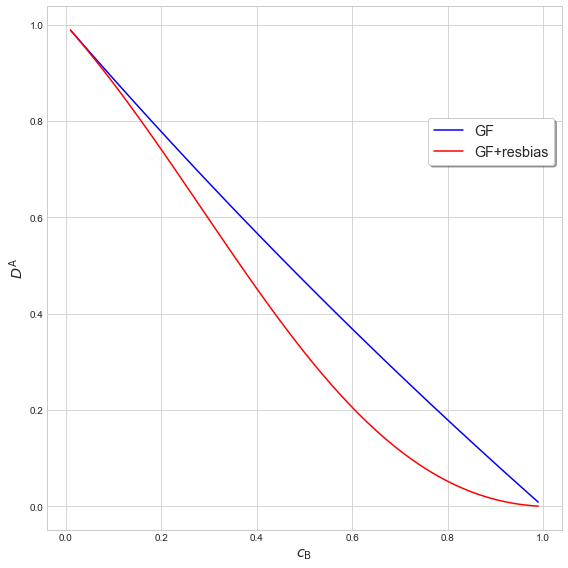

In [376]:
plt.rcParams['figure.figsize'] = (8,8)
fig, ax = plt.subplots()
ax.plot(cBv, D1, 'b', label='GF')
ax.plot(cBv, D2, 'r', label='GF+resbias')
ax.set_ylabel('$D^{\\rm A}$', fontsize='x-large')
ax.set_xlabel('$c_{\\rm B}$', fontsize='x-large')
ax.legend(bbox_to_anchor=(0.5,0.5,0.5,0.3), ncol=1, shadow=True,
          frameon=True, fontsize='x-large', framealpha=1.)
plt.tight_layout()
plt.show()

### Final "analytic" versions
We now produce the analytic (with numerical coefficients) version of our transport coefficients.

In [388]:
num_SCGF, denom_SCGF = truncate_vec(-polydiv(L_SCGF,1)[0]), truncate_vec(divpoly)

In [389]:
num_SCGFbc, denom_SCGFbc = \
truncate_vec(-polydiv(0.5*polymult(PsiB,PsiB),1)[0]), \
truncate_vec(polymult(polymult(divpoly, divpoly), WR))

In [391]:
# check remainders (should be 0 for both)
if __TESTING__:
    print(polydiv(L_SCGF,1)[1], polydiv(0.5*polymult(PsiB,PsiB),1)[1])

(-1.1102230246251565e-16, -1.4343655928804322e-16)

In [411]:
def print_fraction(numer, denom, powstring='**'):
    """
    Returns a string representation of our polynomial ratio
    """
    def format_pow(n):
        if n==0:
            return ''
        if n==1:
            return '*c'
        return '*c' + powstring +'{}'.format(n)
    
    # first, "divide" through until lowest order is constant on both:
    while np.isclose(numer[0], 0) and np.isclose(denom[0], 0):
        numer, denom = numer[1:], denom[1:]
    # second, scale everything by lowest order term in denominator
    scale = denom[np.min(np.nonzero(denom))]
    numer /= scale
    denom /= scale
    s = '('
    for n, coeff in enumerate(numer):
        if not np.isclose(coeff, 0):
            s += '{:+.10g}'.format(coeff) + format_pow(n)
    s += ')/('
    for n, coeff in enumerate(denom):
        if not np.isclose(coeff, 0):
            s += '{:+.10g}'.format(coeff) + format_pow(n)
    s += ')'
    return s    

In [412]:
print(print_fraction(num_SCGF, denom_SCGF))

(+1-1*c)/(+1+0.1415926534*c)


In [415]:
print(print_fraction(num_SCGF, denom_SCGF) + ' + ' +\
      print_fraction(num_SCGFbc, denom_SCGFbc))

(+1-1*c)/(+1+0.1415926534*c) + (-0.01272990904*c+4.554518972*c^2-408.7789226*c^3+242.2968878*c^4+1388.598607*c^5-1268.72564*c^6-960.1143785*c^7+1429.546709*c^8-475.4912083*c^9+48.12615674*c^10)/(+1+359.2297602*c-130.6761861*c^2-597.9247855*c^3+453.718084*c^4-184.779244*c^5-160.9498551*c^6+288.3954999*c^7-5.855536997*c^8-20.27314331*c^9-1.884593043*c^10)


**Note:** both of these polynomials have two factors of $(1-c)$ in them; so we can simplify further...

In [421]:
polydiv(polydiv(polydiv(num_SCGFbc,1)[0],1)[0],1)

(array([-1.26654243e-11, -7.84439180e-12,  1.27299090e-02, -4.51632925e+00,
         3.95191745e+02,  9.56840065e+02,  2.91830024e+02, -3.31112738e+02,
         4.81261567e+01]), -1.8954227076761754e-11)

In [423]:
polydiv(polydiv(denom_SCGFbc,1)[0],1)

(array([-4.26325641e-12,  1.00000000e+00,  3.61229760e+02,  5.90783334e+02,
         2.22412123e+02,  3.07758995e+02,  2.08326624e+02, -5.20556028e+01,
        -2.40423294e+01, -1.88459304e+00]), -7.673861546209082e-12)

In [424]:
SCGFbc_func = print_fraction(num_SCGF, denom_SCGF) + ' + ' +\
      print_fraction(polydiv(polydiv(num_SCGFbc,1)[0],1)[0], 
                     polydiv(polydiv(denom_SCGFbc,1)[0],1)[0])
print(SCGFbc_func)

(+1-1*c)/(+1+0.1415926534*c) + (-0.01272990905*c+4.529059154*c^2-399.7080744*c^3-561.6483202*c^4+665.0100411*c^5+622.9427624*c^6-379.2388949*c^7+48.12615674*c^8)/(+1+361.2297602*c+590.7833342*c^2+222.4121227*c^3+307.7589952*c^4+208.3266238*c^5-52.05560275*c^6-24.0423294*c^7-1.884593043*c^8)
